In [1]:
# This notebook inspects the Ca+ and DA data fro mexperiment tagged as HSFP_636970_2022-11-14-12-34-14
# Use NMF to split channels, and simply plot results. 
# TODO: simplify this notebook, plot residuals based on NMF fit. 
# Structure in the residuals indicates inadequecy of NMF to capture effects that are sustected to be multiplicative. 
# Of course, if the components themselves absorb that factor, the components would look "wrong"
# This is a chicken and egg problem - how do we know that the components we extract look right, and separate out the multiplicative factors?
# We need ground truth, or heuristically modify NMF till we get something that "looks right".

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from timebudget import timebudget
from multiprocessing import Pool

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

import h5py
import pandas as pd
from rich import print as pprint
from sourcesep.utils.config import load_config

from sourcesep.utils.compute import perm_avgabscorr

def standardize(x):
    mean_x = np.mean(x)
    std_x = np.std(x)
    return (x - mean_x)/std_x

def plot_components(H_true, H_pred):
    '''
    Plots the components of the NMF model.

    Args:
        H_true: true components shaped as (n_indicators, n_timesamples)
        H_pred: predicted components shaped as (n_indicators, n_timesamples)
    '''
    perm, corr = perm_avgabscorr(H_pred.T, H_true.T)
    best_perm = perm[np.argmax(corr)]
    print(f'correlation: {np.max(corr):.2f}')

    n_components = H_pred.shape[0]
    fig, ax = plt.subplots(n_components, 1, figsize=(6, 6))
    for i in range(n_components):
        ax[i].plot(standardize(H_pred[best_perm[i], :]),
                   alpha=0.8, c='r', label='fit (standardized)')
        ax[i].plot(standardize(H_true[i, :]), alpha=0.3,
                   c='b', label='true (standardized)')
        ax[i].set(xlabel='time samples', ylabel='amplitude', xlim=(0, 1000))

    plt.legend()
    plt.show()
    return fig, ax


def plot_mixing(L_arr, W_true, W_pred, n_lasers=5, n_factors=3):
    '''
    Plots the mixing matrix for each laser.

    Args:
        L_arr: array of wavelengths
        W_true: true mixing matrix shaped as (n_channels, n_indicators)
        W_pred: predicted mixing matrix shaped as (n_channels, n_indicators)
    '''
    scale_factor = np.mean(W_pred, 0, keepdims=True)/np.mean(W_true, 0, keepdims=True)
    W_pred = W_pred/(scale_factor + 1e-10)
    fig, ax = plt.subplots(n_lasers, 2, figsize=(7, 6))

    for laser in range(n_lasers):
        idx = np.arange(L_arr.size) + L_arr.size*laser
        for factor in range(n_factors):
            ax[laser, 0].plot(L_arr, W_pred[idx, factor])
            ax[laser, 0].set(ylim=(-0.1, 1.1))

    for laser in range(n_lasers):
        idx = np.arange(L_arr.size) + L_arr.size*laser
        for factor in range(n_factors):
            ax[laser, 1].plot(L_arr, W_true[idx, factor])
            ax[laser, 1].set(ylim=(-0.1, 1.1))
    ax[n_lasers-1, 0].set(xlabel='wavelengths', ylabel='fitted mixing')
    ax[n_lasers-1, 1].set(xlabel='wavelengths', ylabel='imposed mixing')
    for laser in range(n_lasers):
        ax[laser, 0].set_title('Fitted')
        ax[laser, 1].set_title('True')
    plt.tight_layout()
    return fig, ax

In [2]:
# These are combined responses of autofluorescence, Ca sensor (EGFP), and DA sensor (mApple).

from sourcesep.sim import SimData
paths = load_config(dataset_key='all')
sim = SimData(T=10000, cfg_path=paths['root'] / "sim_HSFP_636970_2022-11-14-12-34-14.toml")
_ = sim.get_S()
_ = sim.get_W()
_ = sim.get_E()
pprint(sim.W_df)

Paths are for dataset tagged: all
Paths are for dataset tagged: all


405     473     561
EGFP    0.1732  0.8143  0.0043
mApple  0.0069  0.0920  0.8972

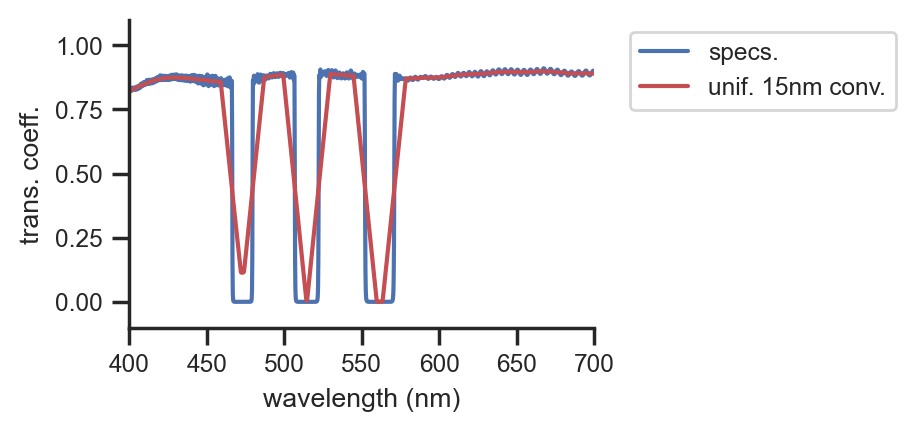

In [3]:
import pandas as pd
from scipy.ndimage import uniform_filter1d

df_list = []
for lam in [473, 514, 561]:
    df = pd.read_excel(paths['spectra'] / f'Semrock_{lam}nm_notch.xlsx', skiprows=13)  # Skip the first 10 rows if they contain headers or metadata
    df.columns = ['wavelength', 'trans']
    df_list.append(df)

assert np.all(df_list[0]['wavelength'].values == df_list[1]['wavelength'].values)
assert np.all(df_list[0]['wavelength'].values == df_list[2]['wavelength'].values)

# transmission of each notch should be multiplied for overall transmission
ideal_trans = df_list[0]['trans'] * df_list[1]['trans'] * df_list[2]['trans']
wavelength = df_list[0]['wavelength'].values

conv_window = 15 # in nm
lam_sampling_rate = np.mean(np.diff(wavelength))
df = pd.DataFrame({'wavelength': wavelength, 'ideal_trans': ideal_trans})

df['eff_trans'] = uniform_filter1d(df['ideal_trans'], int(conv_window / lam_sampling_rate))

f, ax = plt.subplots(1,1, figsize=(3,2))
ax.plot(df['wavelength'], df['ideal_trans'], c='b', label=f'specs.')
ax.plot(df['wavelength'], df['eff_trans'], c='r',label=f'unif. 15nm conv.')
ax.set(xlabel='wavelength (nm)', ylabel='trans. coeff.', xlim=(400, 700), ylim=(-0.1, 1.1))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

eff_trans = np.interp(sim.L_arr, df['wavelength'], df['eff_trans'])



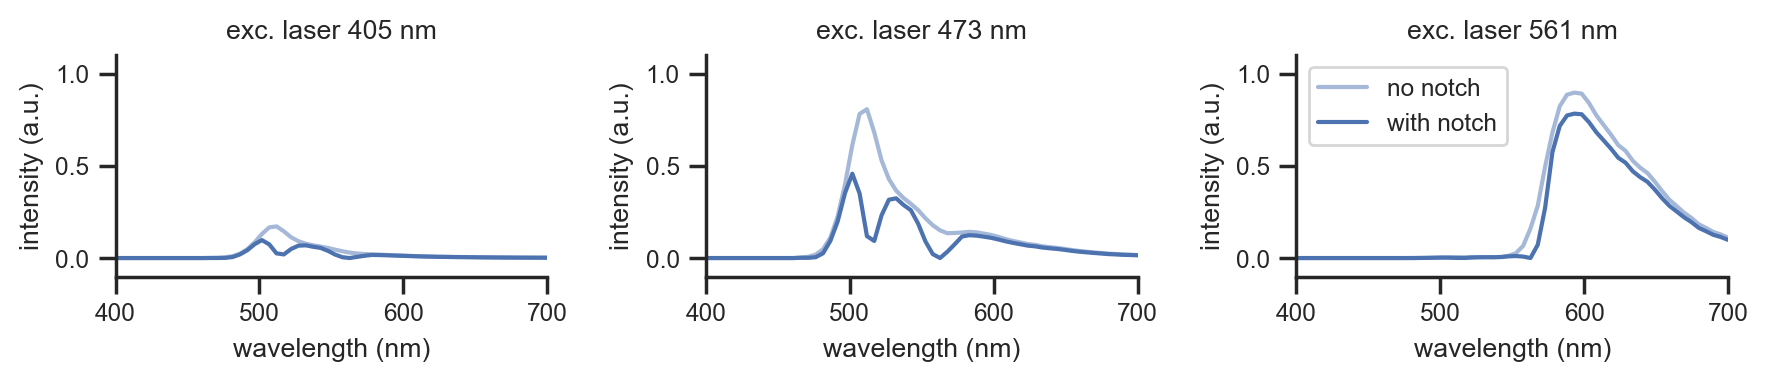

In [4]:
lasers = [473, 514, 561]
S = (sim.W.T @ sim.S)
S_notch = (sim.W.T @ sim.S) * eff_trans.reshape(1,-1)

f, ax = plt.subplots(1,3, figsize=(9,2))
for j in range(3):
    ax[j].plot(sim.L_arr, S[j,:], '-b', alpha=0.5, label='no notch')
    ax[j].plot(sim.L_arr, S_notch[j,:], '-b', label='with notch')
    ax[j].set(xlim=(400, 700), 
              ylim=(-0.1, 1.1), 
              xlabel='wavelength (nm)', 
              ylabel='intensity (a.u.)', 
              title=f'exc. laser {sim.W_df.columns.values[j]} nm')

plt.tight_layout()
plt.legend()
plt.show()

In [5]:
paths = load_config(dataset_key='all')
f = h5py.File(paths['root'] / 'HSFP_636970_2022-11-14-12-34-14_data_preprocessed.hdf5', 'r')
print(f.keys())

xj = {}
xj[0] = f['Channel3'][:] #405
xj[1] = f['Channel2'][:] #473
xj[2] = f['Channel1'][:] #560

t = f['Time'][:]
l = f['Wavelength'][:]

print(f'\nsampling frequency: {1/(np.max(t) / t.size):0.2f} Hz')
print(f'length of recording: {np.max(t)-np.min(t):0.2f} seconds')
print(f'\neach channel has dimensions of {xj[0].shape}')
print(f'min. wavelength: {np.min(l):0.2f} nm')
print(f'max. wavelength: {np.max(l):0.2f} nm')

Paths are for dataset tagged: all
<KeysViewHDF5 ['Channel1', 'Channel2', 'Channel3', 'Time', 'Wavelength']>

sampling frequency: 40.00 Hz
length of recording: 441.64 seconds

each channel has dimensions of (17666, 300)
min. wavelength: 400.00 nm
max. wavelength: 699.00 nm


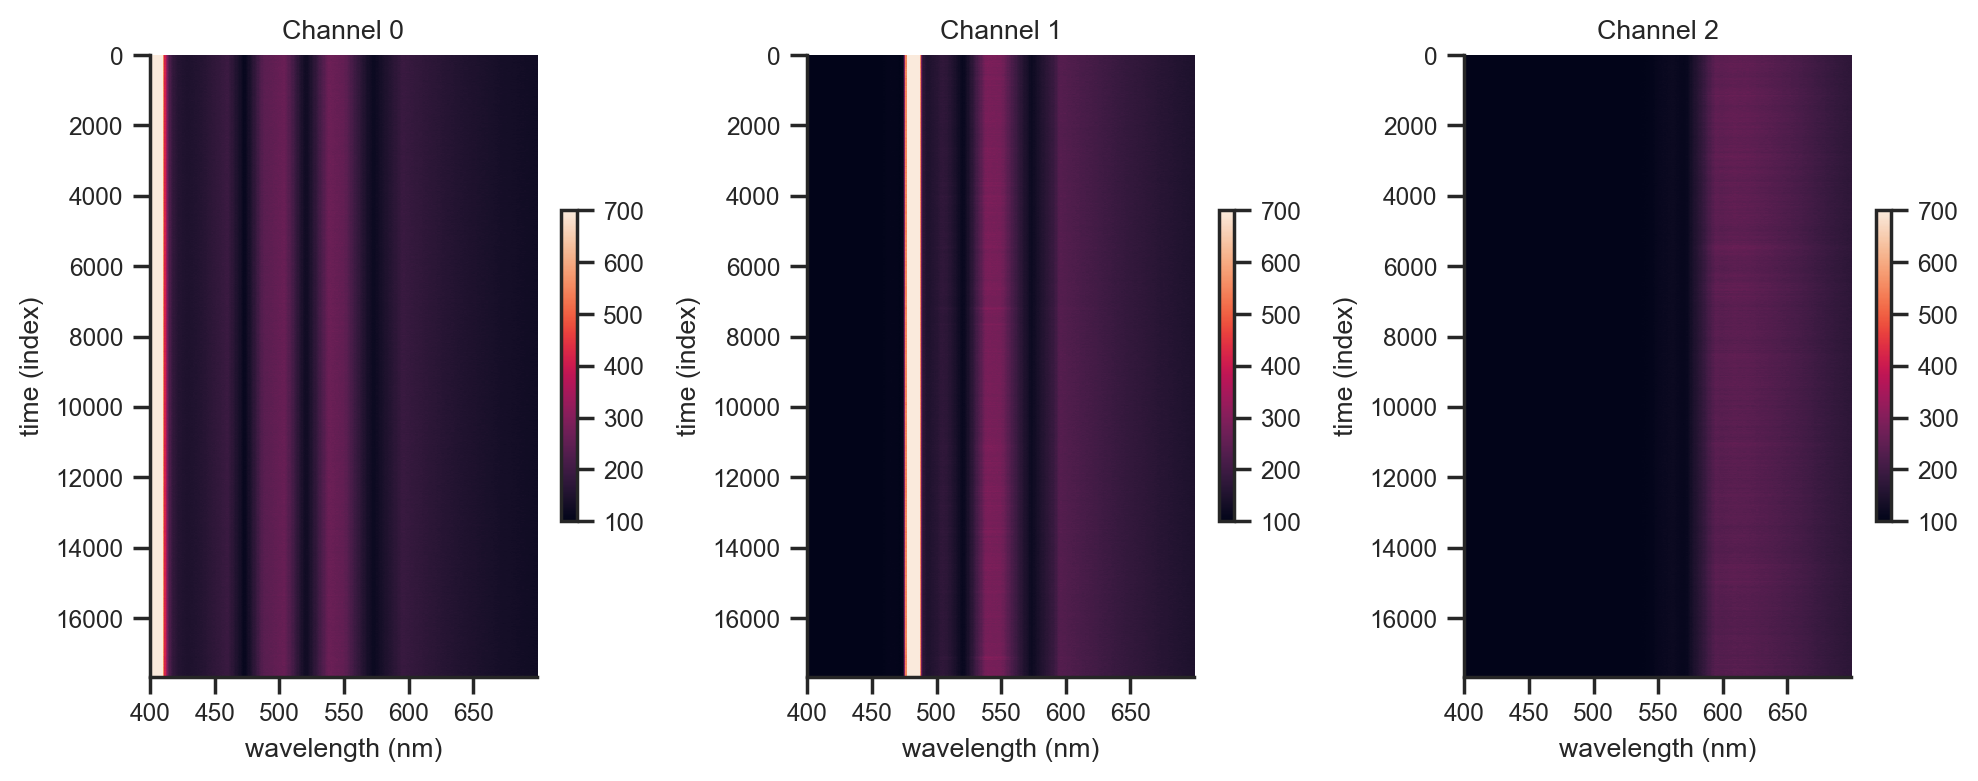

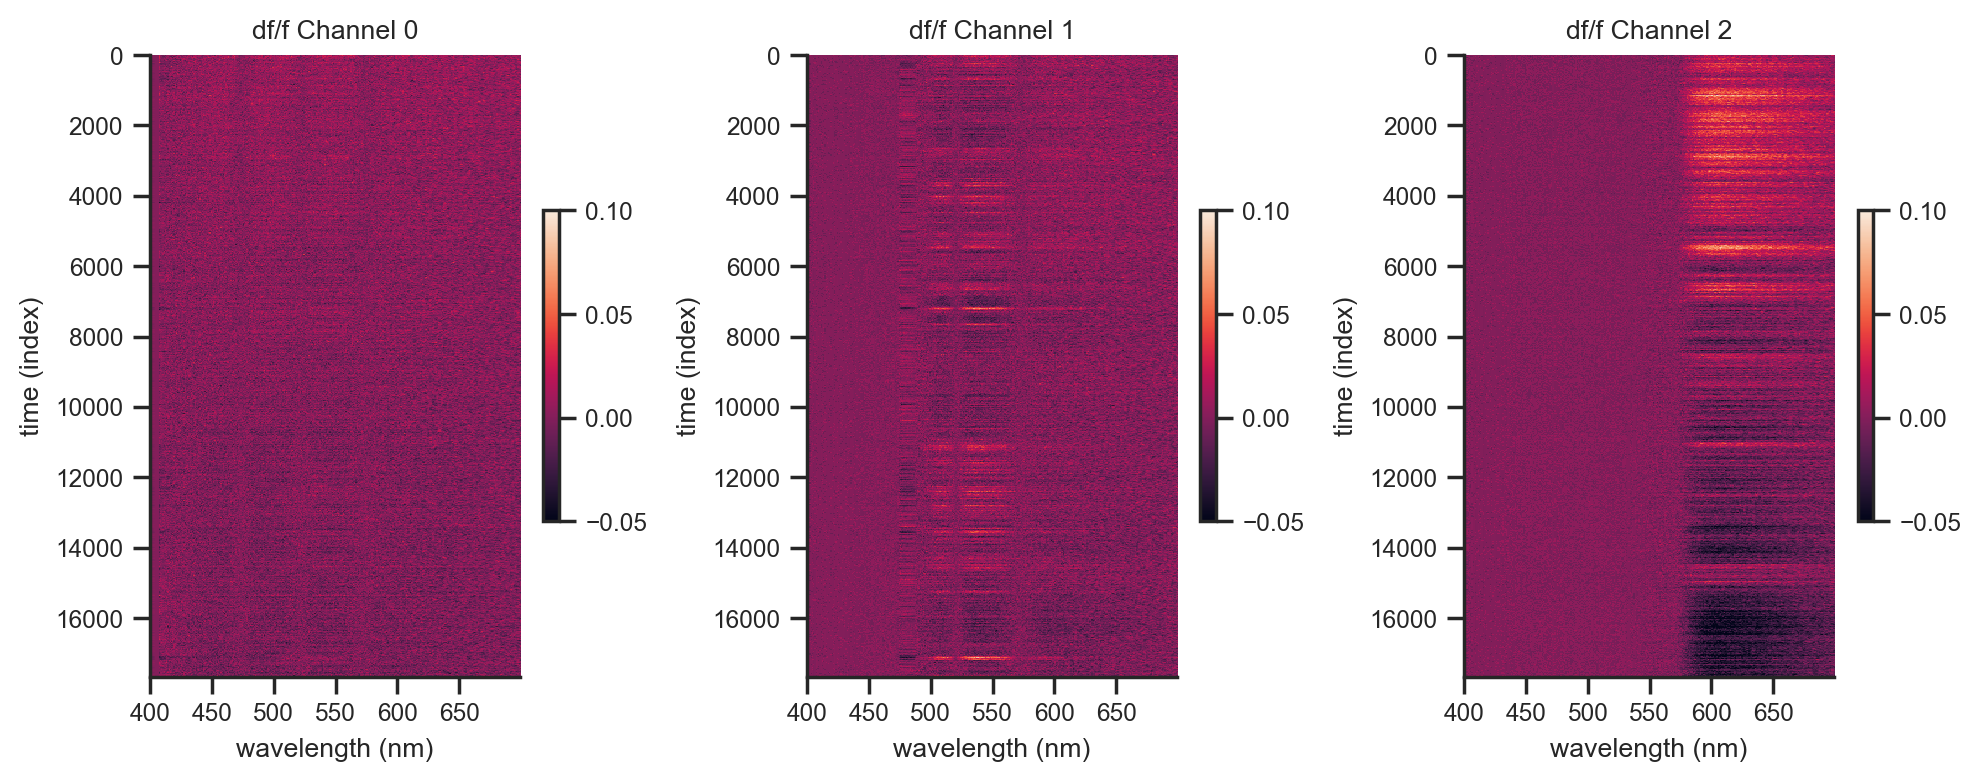

In [6]:
# show raw intensities

f, ax = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    f.colorbar(ax[i].imshow(xj[i], interpolation='nearest', aspect='auto', vmin=100, vmax=700), ax=ax[i], shrink=0.5)
    ax[i].grid(visible=False)
    ax[i].set(xlabel='wavelength (nm)', ylabel='time (index)', title=f'Channel {i}')
    ax[i].set_xticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])

plt.tight_layout()

# show df/f

Xj = {}
for i in range(3):
    mean_xj = np.mean(xj[i], axis=0, keepdims=True)
    Xj[i] = (xj[i] - mean_xj)/mean_xj

f, ax = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    f.colorbar(ax[i].imshow(Xj[i],
                            interpolation='nearest',
                            aspect='auto',
                            vmin=-0.05, vmax=0.1),
               ax=ax[i], shrink=0.5)
    ax[i].grid(False)
    ax[i].set(xlabel='wavelength (nm)', ylabel='time (index)', title=f'df/f Channel {i}')
    ax[i].set_xticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])

plt.tight_layout()
plt.show()

DA signal is excited by the 560 laser, and peak emission is at ~610 nm 
       Here: channel 2 seems to be the 560 nm laser


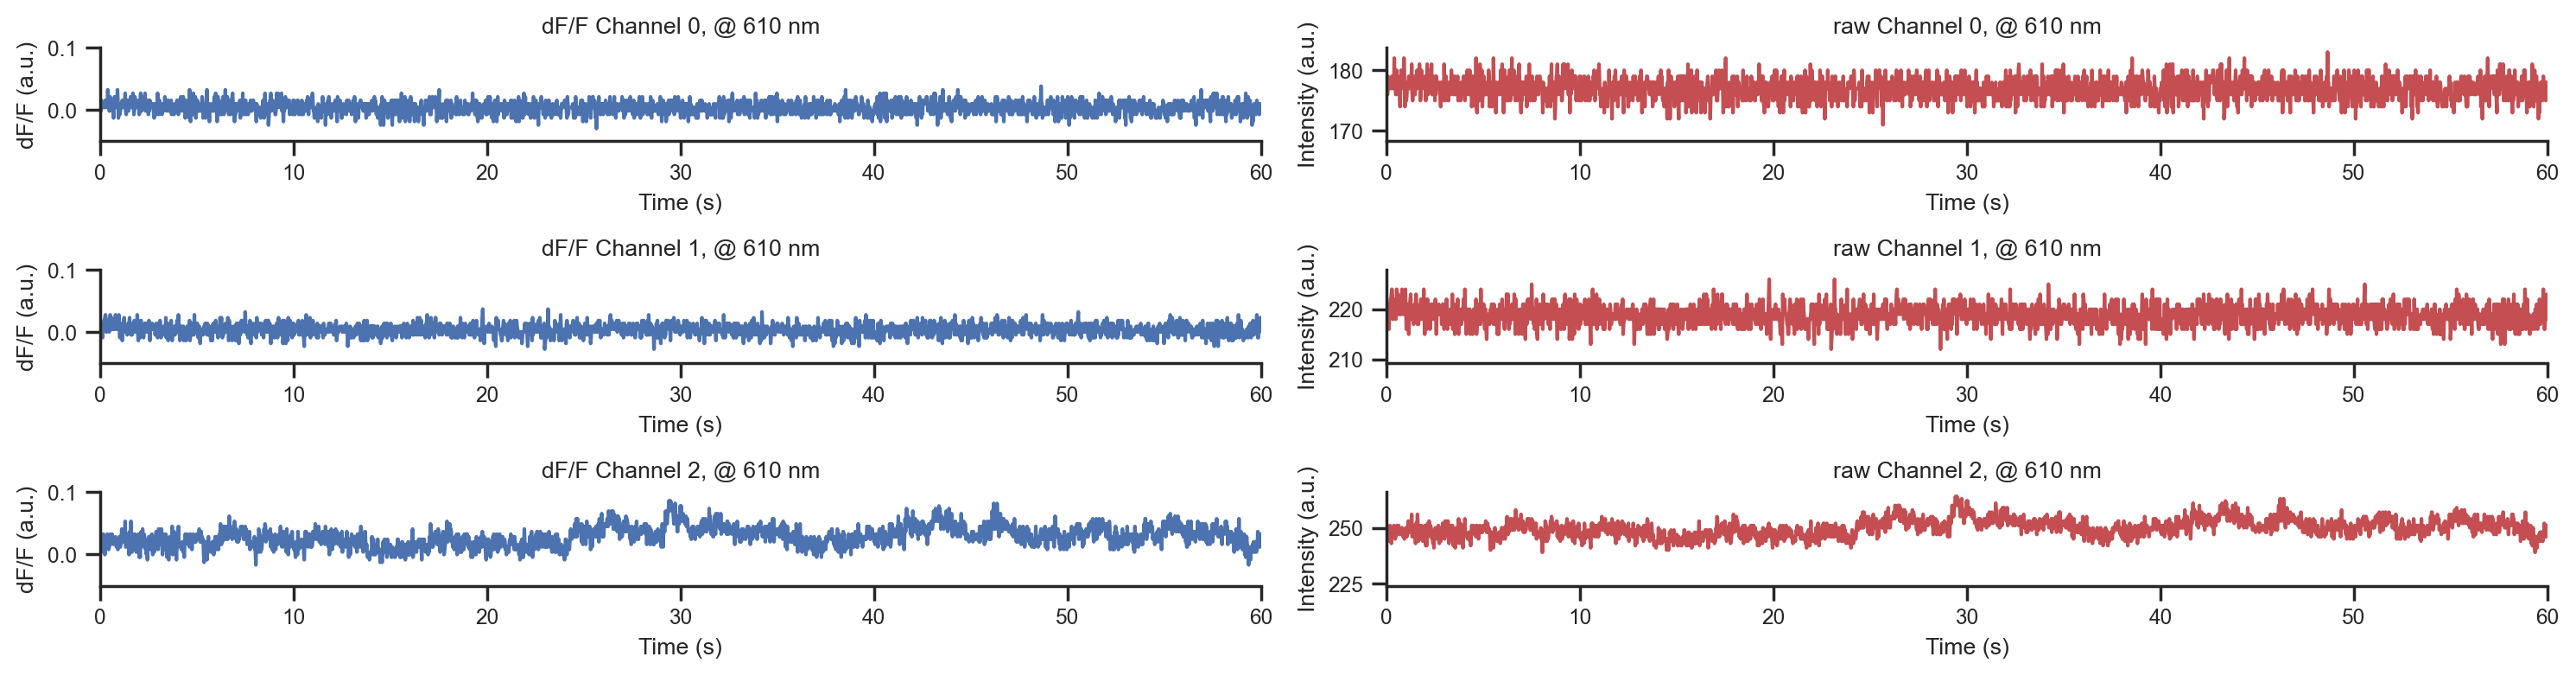


Ca signal is excited by the 473 laser, and emitted at 530 nm 
       Here: channel 1 seems to be the 473 nm laser


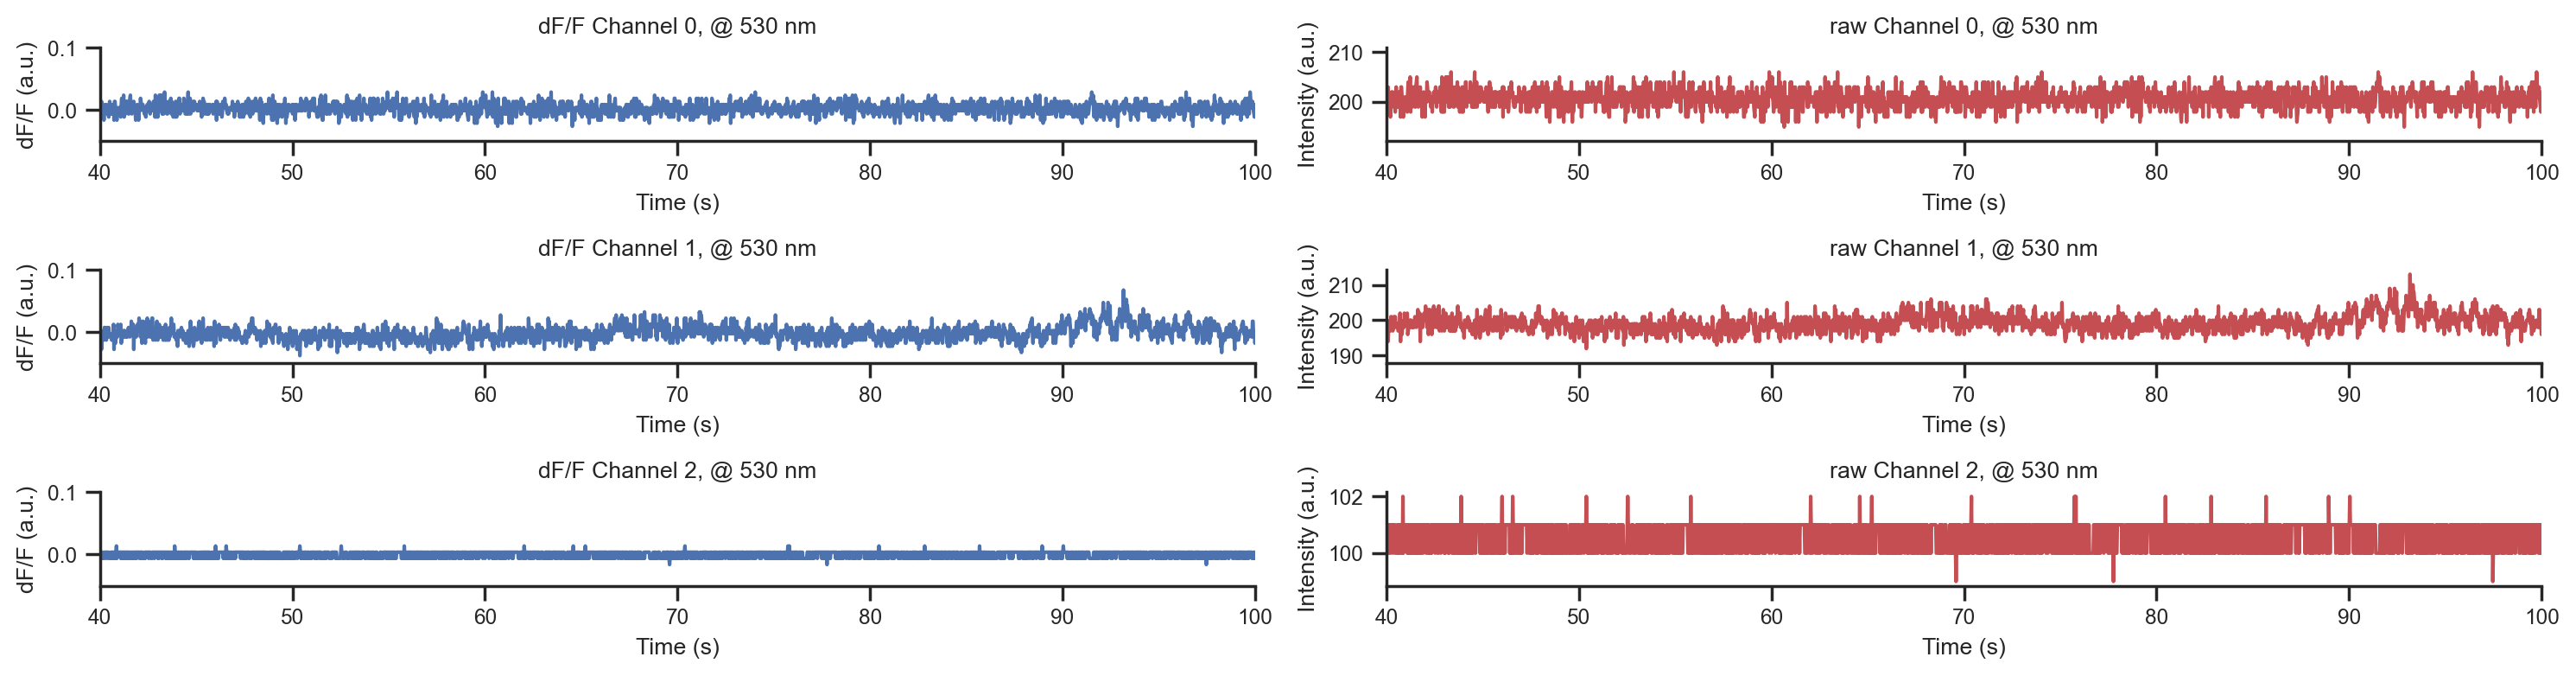


405 laser does not excite either sensor 



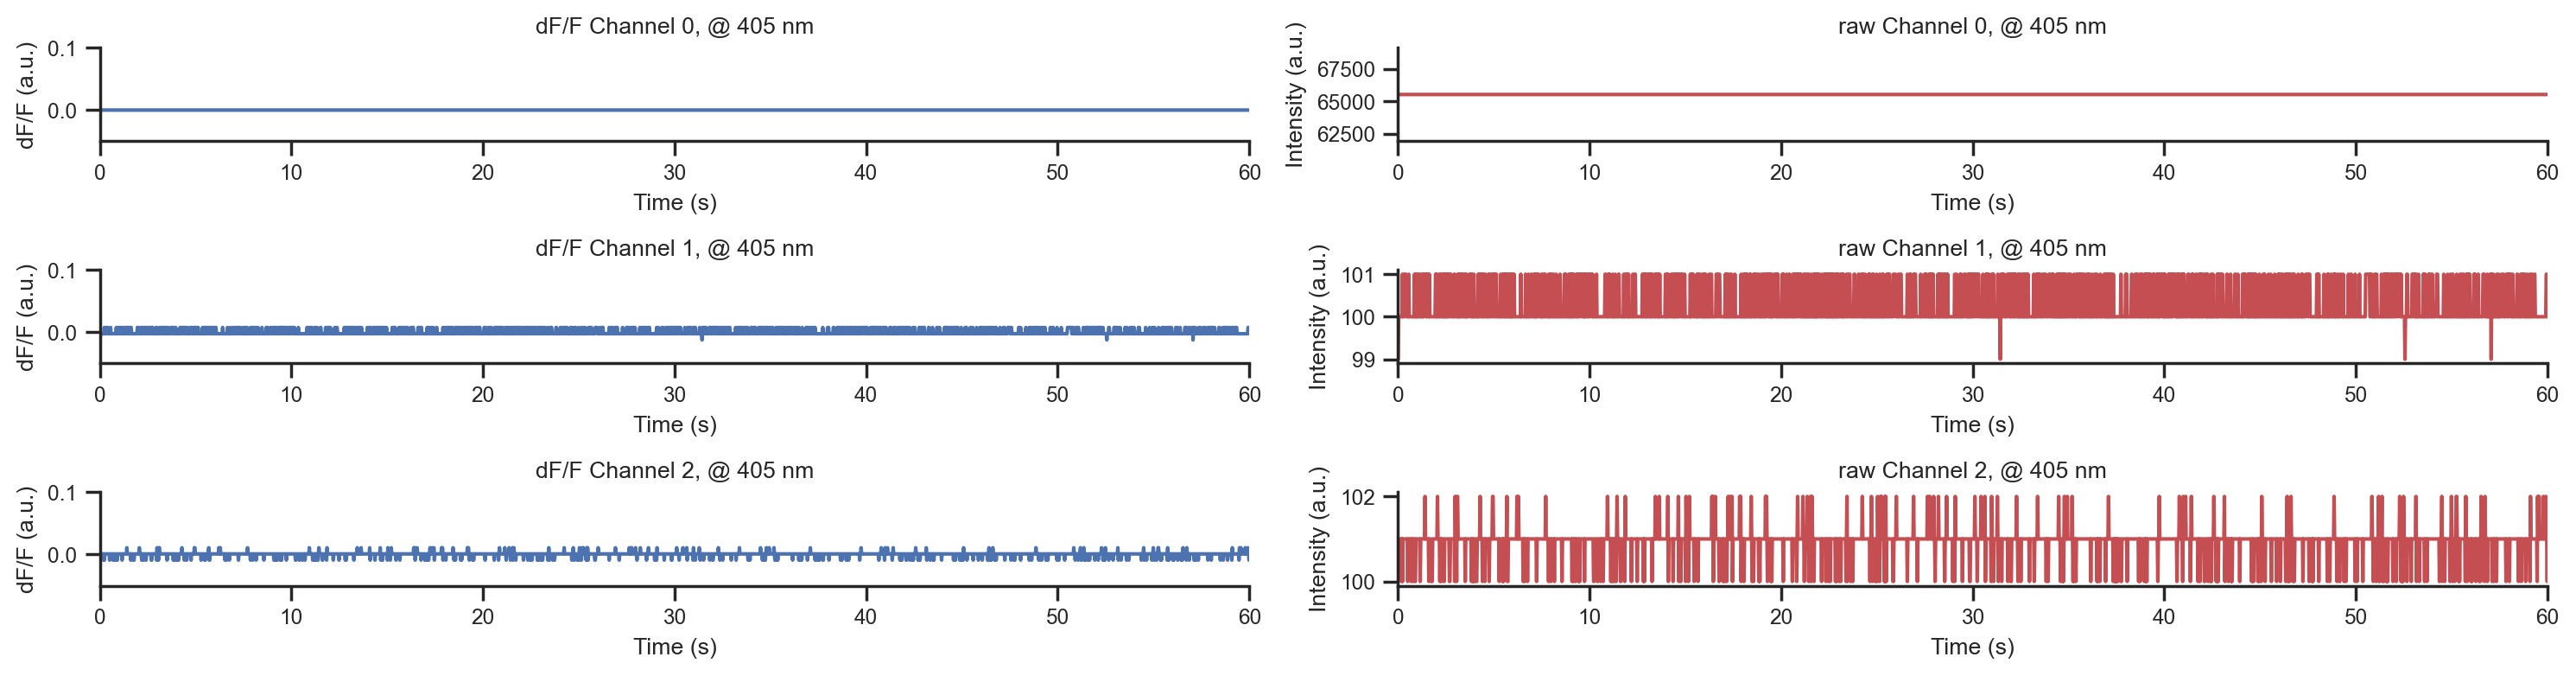

In [7]:
# Channels correspond to different lasers
# The lasers used are:
# channel 2 - em_wavelength_nm = 561
# channel 1 - em_wavelength_nm = 473
# channel 0 - em_wavelength_nm = 405

def df_over_f(x):
    mean_x = np.mean(x)
    return (x - mean_x)/mean_x

def plot_channels(l, t, xj, em_freq, xlim=(0,60)):
    f, ax = plt.subplots(3,2,figsize=(15,4))
    k=0
    for i in range(3):
        ax[i,k].plot(t.ravel(),df_over_f(xj[i][:,l==em_freq].ravel()))
        ax[i,k].set(xlim=xlim, 
                  ylim=(-0.05, 0.1), 
                  xlabel='Time (s)', 
                  ylabel='dF/F (a.u.)', 
                  title=f'dF/F Channel {i}, @ {em_freq} nm')
    k=1
    for i in range(3):
        ax[i,k].plot(t.ravel(),xj[i][:,l==em_freq].ravel(), c='r')
        ax[i,k].set(xlim=xlim, 
                  xlabel='Time (s)', 
                  ylabel='Intensity (a.u.)', 
                  title=f'raw Channel {i}, @ {em_freq} nm')
        
    plt.tight_layout()
    plt.show()
    return

print('DA signal is excited by the 560 laser, and peak emission is at ~610 nm \n \
      Here: channel 2 seems to be the 560 nm laser')
plot_channels(l, t, xj, em_freq=610, xlim=(0,60))

print('\nCa signal is excited by the 473 laser, and emitted at 530 nm \n \
      Here: channel 1 seems to be the 473 nm laser')
plot_channels(l, t, xj, em_freq=530, xlim=(40,100))

print('\n405 laser does not excite either sensor \n')
plot_channels(l, t, xj, em_freq=405, xlim=(0,60))

[Text(0.5, 0, 'Time (s)'),
 Text(0, 0.5, 'Amplitude'),
 Text(0.5, 1.0, 'Ca'),
 (0.0, 450.0)]

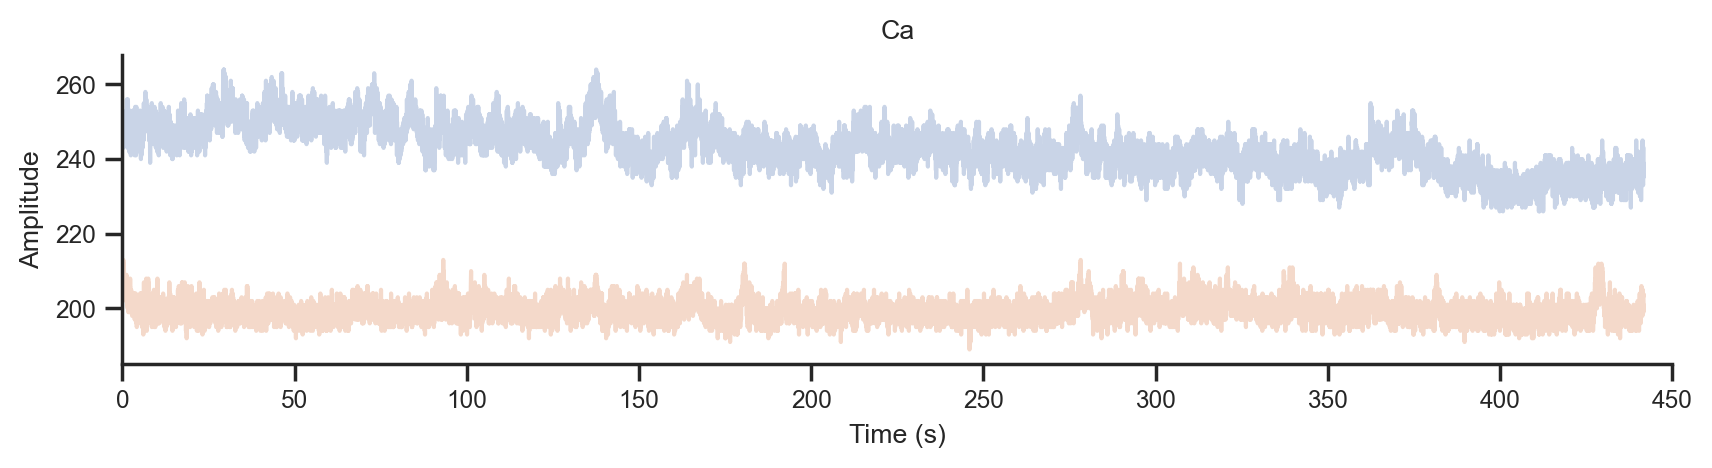

In [8]:
# Preprocessing?
fig,ax = plt.subplots(1,1,figsize=(10,2))
ax.plot(t, xj[2][:,l==610], '-', alpha = 0.3)
ax.set(xlabel='Time (s)', ylabel='Amplitude', title='DA', xlim = (0,450))

ax.plot(t, xj[1][:,l==530], '-', alpha = 0.3)
ax.set(xlabel='Time (s)', ylabel='Amplitude', title='Ca', xlim = (0,450))

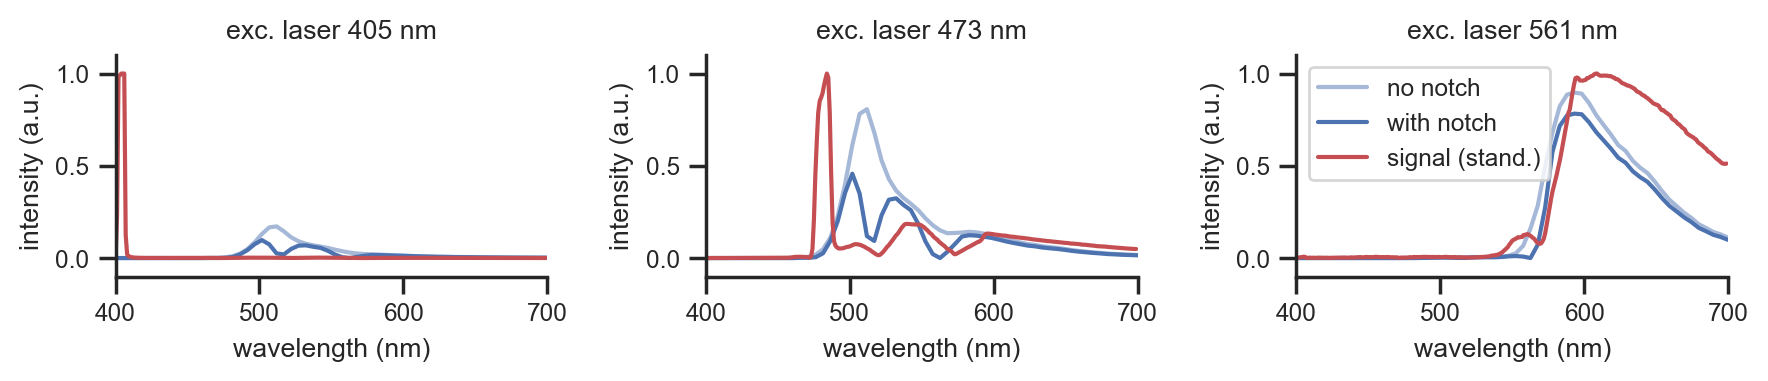

In [9]:
# Comparing average signal in spectral dimension to expected spectral response
lasers = [473, 514, 561]
S = (sim.W.T @ sim.S)
S_notch = (sim.W.T @ sim.S) * eff_trans.reshape(1,-1)

f, ax = plt.subplots(1,3, figsize=(9,2))
for j in range(3):
    data = np.squeeze(np.mean(xj[j], axis=0))
    data = data - np.min(data)
    data = data / np.max(data)
    ax[j].plot(sim.L_arr, S[j,:], '-b', alpha=0.5, label='no notch')
    ax[j].plot(sim.L_arr, S_notch[j,:], '-b', label='with notch')
    ax[j].plot(l, data, 'r-', label='signal (stand.)')
    ax[j].set(xlim=(400, 700), 
              ylim=(-0.1, 1.1), 
              xlabel='wavelength (nm)', 
              ylabel='intensity (a.u.)', 
              title=f'exc. laser {sim.W_df.columns.values[j]} nm')
    
plt.tight_layout()
plt.legend()
plt.show()

# NMF

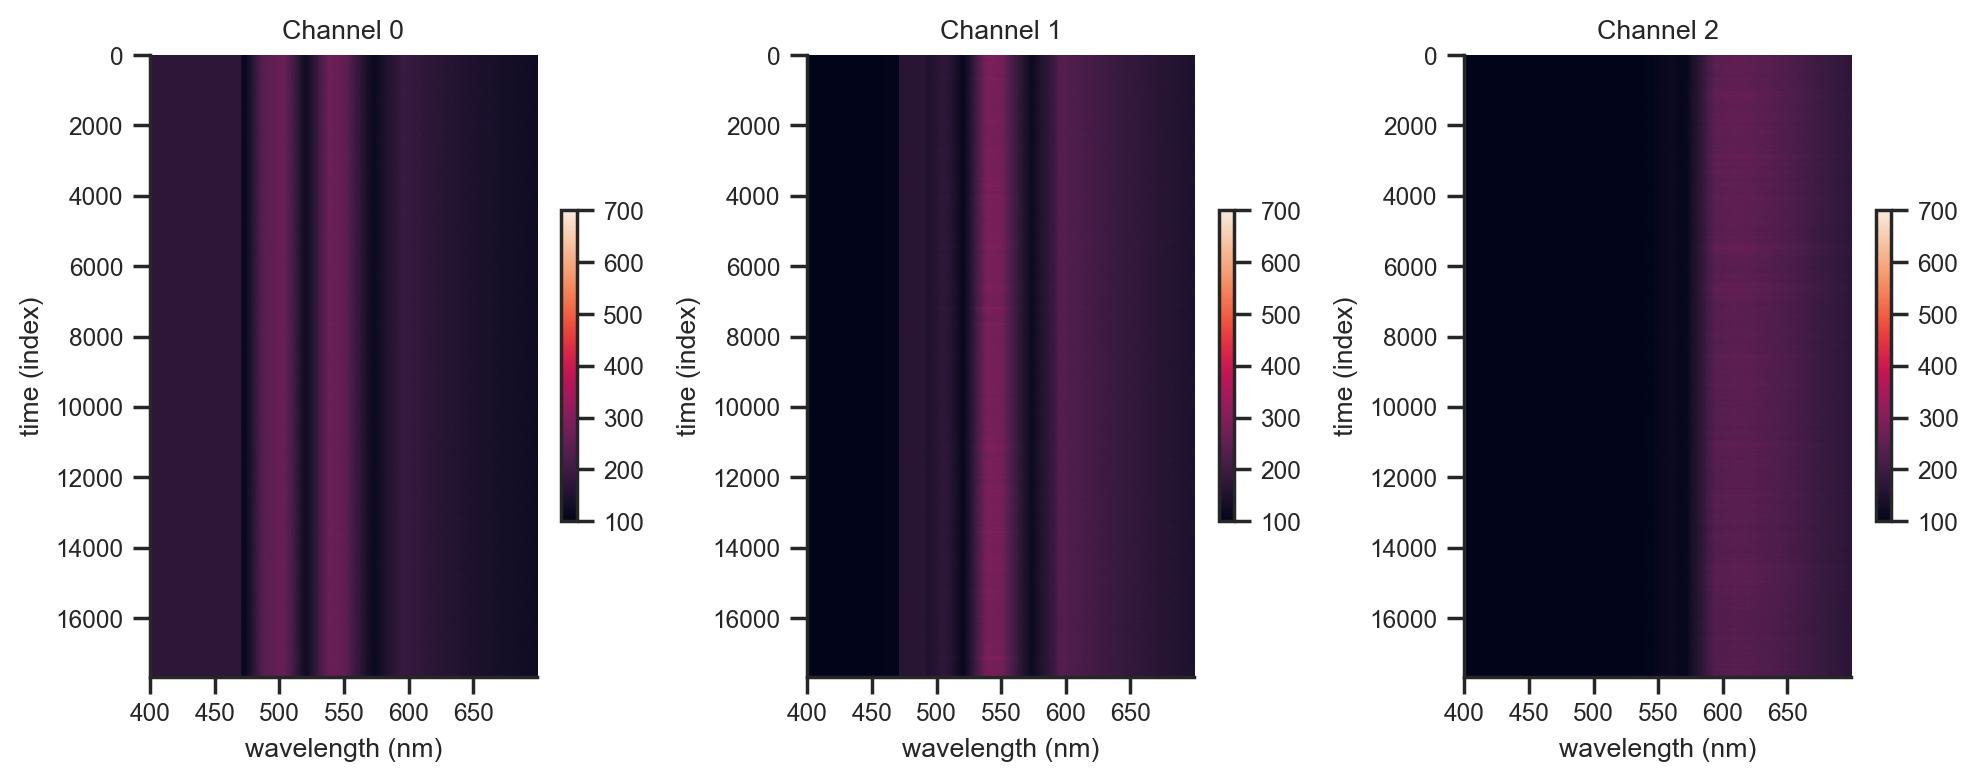

In [10]:
n_components = 2

eff_trans_interp = np.interp(l, sim.L_arr, eff_trans)
S_interp = np.concatenate([np.interp(l, sim.L_arr, sim.S[0].squeeze()).reshape(1, -1),
                           np.interp(l, sim.L_arr, sim.S[1].squeeze()).reshape(1, -1)], axis=0)
S_interp_eff = np.einsum('il,l->il', S_interp, eff_trans_interp)

Mjl = np.einsum('ij,il->ijl', sim.W, S_interp_eff)
Mjl = Mjl.reshape(n_components, -1)
M = Mjl.T.copy()
M.shape

H_init = np.concatenate((xj[1][:, l == 530].reshape(-1, 1),
                        xj[2][:, l == 610].reshape(-1, 1)), axis=1)
H_init = H_init.T.astype(float)


def remove_laser_signal(x, j, l):
    if j == 0:
        block_region = l < 470
        x[:,block_region] = np.mean(x[:,~block_region])
    elif j == 1:
        block_region = np.logical_and(l > 470, l < 490)
        x[:,block_region] = np.mean(x[:,~block_region])
    elif j == 2:
        pass
    return x

X = np.concatenate([remove_laser_signal(xj[j], j, l) for j in range(3)], axis=1)
X = X.astype(float)

f, ax = plt.subplots(1, 3, figsize=(10, 4))
for i in range(3):
    f.colorbar(ax[i].imshow(remove_laser_signal(xj[i], i, l), interpolation='nearest', aspect='auto', vmin=100, vmax=700), ax=ax[i], shrink=0.5)
    ax[i].grid(visible=False)
    ax[i].set(xlabel='wavelength (nm)', ylabel='time (index)', title=f'Channel {i}')
    ax[i].set_xticks(np.arange(0, 300, 50), labels=l[np.arange(0, 300, 50)])

plt.tight_layout()

In [11]:
print(f'W: {M.shape}')
print(f'H: {H_init.shape}')
print(f'X: {X.shape}')
print('---')
O_noisy = X.T
O_simple = X.T
H_true = H_init.copy()
W_true = M.copy()
W_init = M.copy()

print(f'O_noisy: {O_noisy.shape}')
print(f'O_simple: {O_simple.shape}')
print(f'H_true: {H_true.shape}')
print(f'W_true: {W_true.shape}')
print(f'W_init: {W_init.shape}')

W: (900, 2)
H: (2, 17666)
X: (17666, 900)
---
O_noisy: (900, 17666)
O_simple: (900, 17666)
H_true: (2, 17666)
W_true: (900, 2)
W_init: (900, 2)


In [15]:
import numpy as np
from sklearn.decomposition import NMF

scale_factor = 1/200
t_start=0
t_end=15000
H_init = H_init[:,t_start:t_end]

model = NMF(n_components=n_components, init='custom',
            solver='mu', beta_loss='frobenius',
            tol=1e-10, max_iter=5000, random_state=None,
            alpha_W=0.0, alpha_H=0, l1_ratio=0.0,
            verbose=0, shuffle=False)



In [16]:
W_pred = model.fit_transform(O_noisy[:,t_start:t_end]*scale_factor, W=W_init, H=H_init)
H_pred = model.components_


/home/rohan/miniconda3/envs/sourcesep2/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(


correlation: 0.79


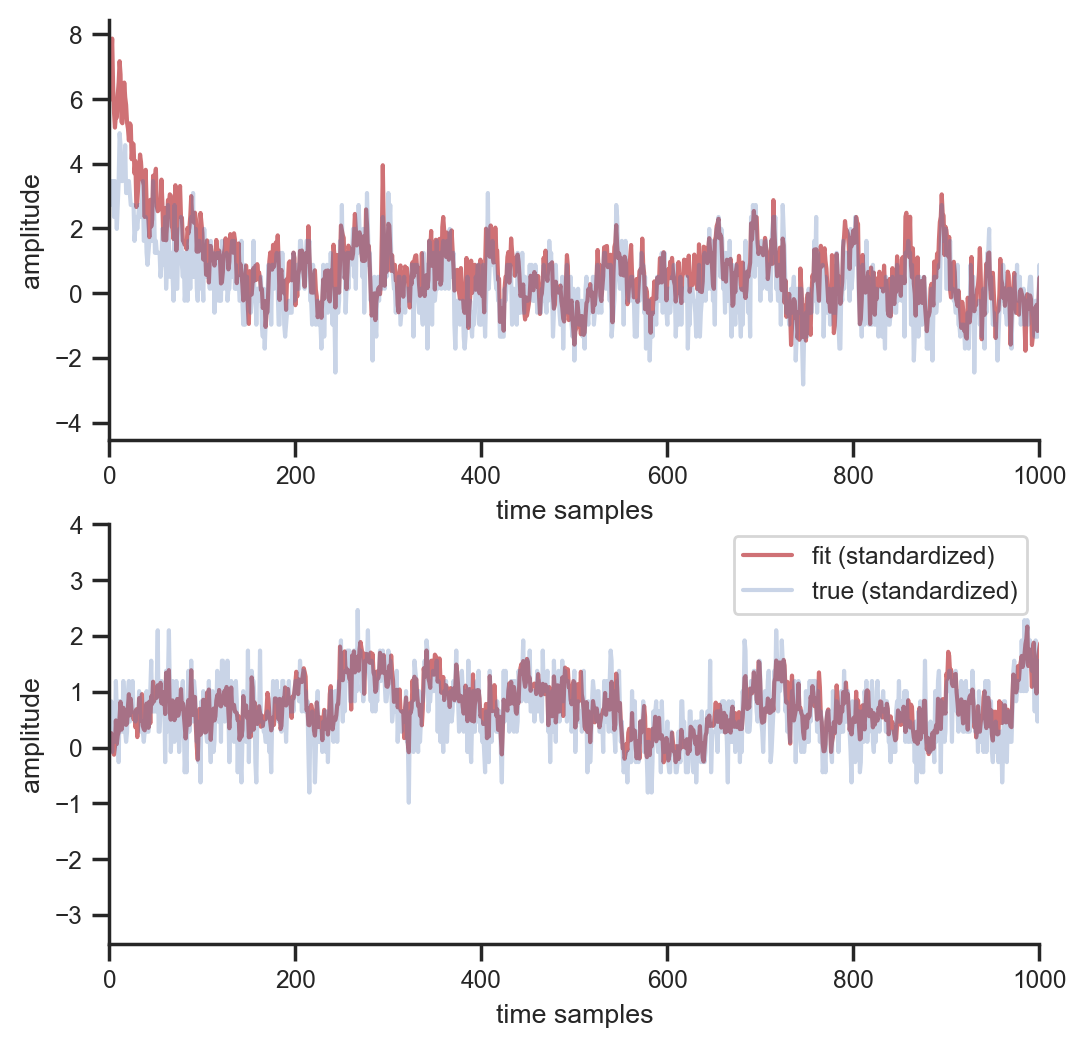

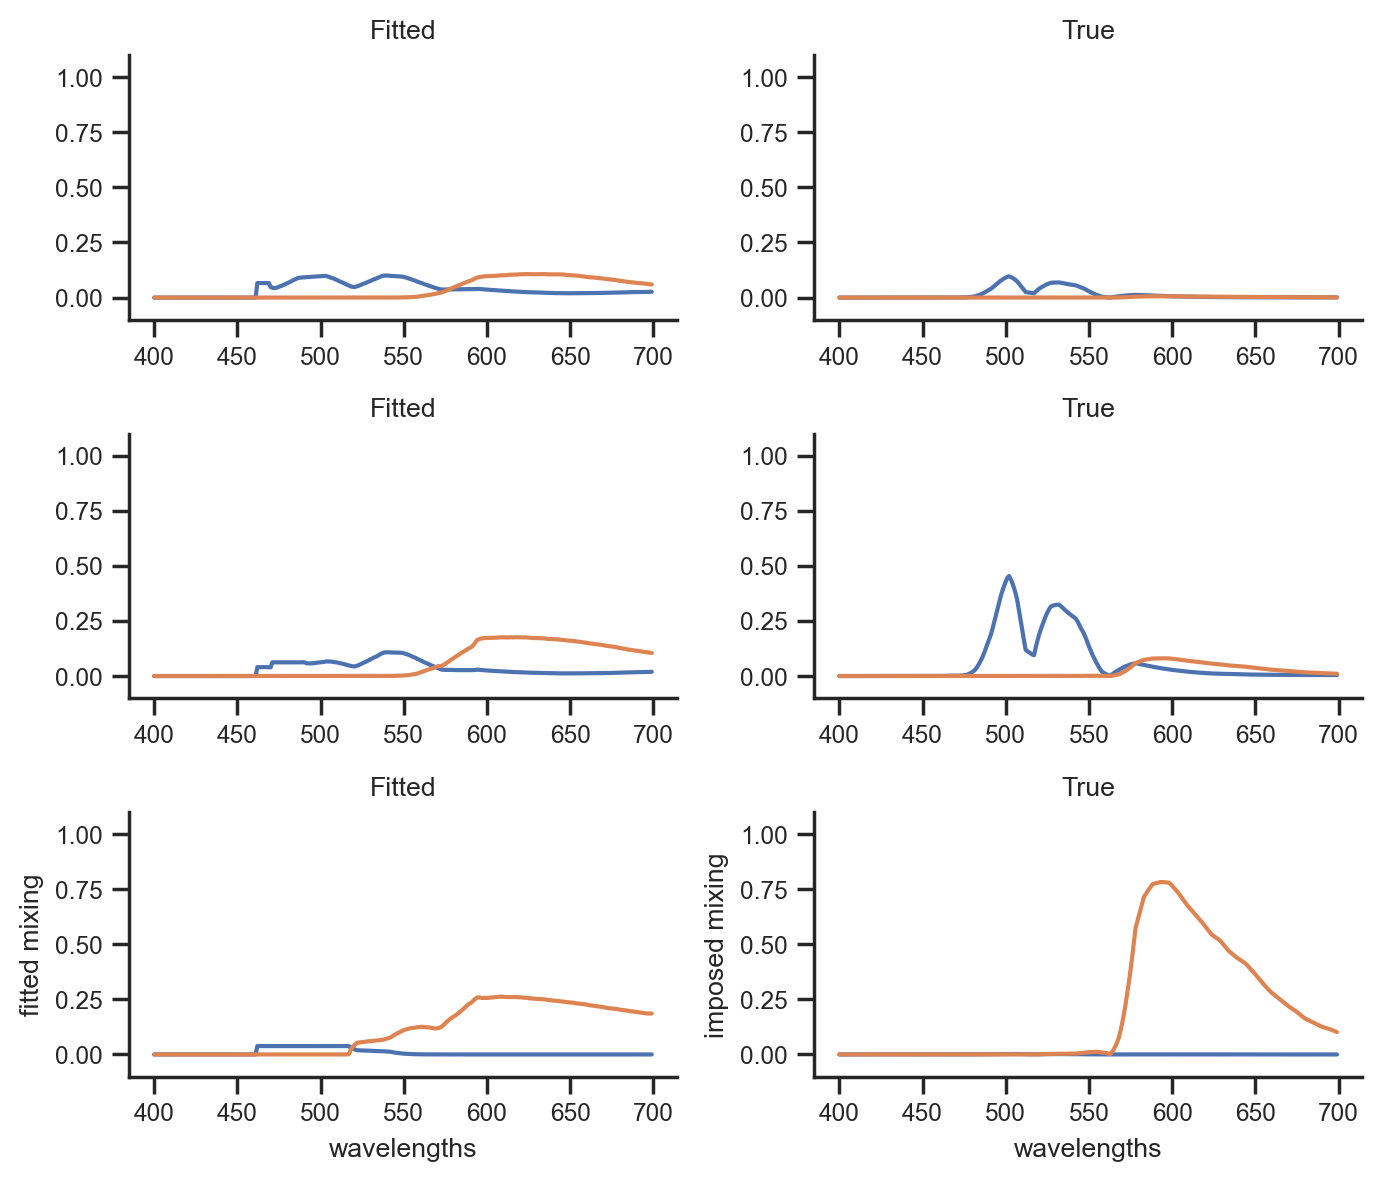

In [17]:

fig, ax = plot_components(H_true[:,t_start:t_end], H_pred)
fig, ax = plot_mixing(l, W_true, W_pred, n_lasers=3, n_factors=2)
#plt.show()

# errors
##err = (O_simple[:,t_start:t_end]*scale_factor - W_pred@H_pred)/scale_factor
#print(f'avg. L1 error: {np.mean(np.abs(err)):.8f}')
#print(f'avg. L2 error: {np.mean(np.abs(err**2)):.8f}')
#assert np.allclose(W_true@H_true[:,t_start:t_end], O_simple[:,t_start:t_end], atol=1e-7), 'data not recovered'